# Programming Assignment II: Explainability

In this assignment you will train machine learning models and experiment with techniques discussed in the lectures.
This assignment makes use of existing Python libraries for some questions. We have provided links to tutorials/examples if you're not familiar with them yet.

All code that you implement should be in this notebook. You should submit:
* This notebook with your code added. Make sure to add enough documentation. Also provide complete answers to the more theoretical questions in this notebook. These questions are followed by an 'answer indent':
> Answer:

The notebook .ipynb should have the name format `Prog_Explainability_Group_X.ipynb`, where X is your programming group ID.

Important notes:
* Deadline for this assignment is **Monday, June 3, 17:00**.
* Send it to both Mart Koek (m.j.koek@uu.nl) and Heysem Kaya (h.kaya@uu.nl), CCing your programming partner.
* Title of the email: [INFOMHCML] Explainability programming assignment submission X, with X the number of your group.
* There will be a lab session to assist you with the assignment on **Thursday, May 30, between 13:15-15:00 at DALTON 500 - 6.27 and DALTON 500 - 7.27**.

### Installation

For this assignment, we are going to use the following Python packages:
graphviz, matplotlib, pandas, statsmodels, openpyxl, interpret, and scikit-learn.

In [ ]:
# Installing packages
!pip install graphviz
!pip install matplotlib pandas statsmodels openpyxl
!pip install interpret
!pip install scikit-learn --upgrade

### Read the data
We are going to use the ChaLearn LAP-FI (First Impressions) Dataset. This dataset contains 10.000 data points, which correspond to videos collected from YouTube and annotated via Amazon Mechanical Turk for the BIG-5 personality impressions: openness, extraversion, conscientiousness, neuroticism, agreeableness.

These five personality impression scores will be used as features to predict the outcome variable: a job interview invitation.

For a detailed description, see the [paper of the dataset](https://ieeexplore.ieee.org/abstract/document/7966041?casa_token=1Y03H5ykCqsAAAAA:VLhCcjAgByJ2hTdKhulmIUiXIVepEJfFyB7HM0XVts7bN8Gi8wMsiTT0qZ--I_kq8wiUHIpPN7es).


1.   If you use Google Colab, upload 'all_df.csv' (you can find this file on blackboard) through the upload button in the Files tab.
  - Copy the path of the file;
  - Run the cell below with your path. This will ask you for permission to access your Google Drive files and then you can access the data.
2.   If you are running this notebook at your own machine (jupyter notebook), locate the 'all_df.csv' file in the same folder this notebook exists. Then you can run the second cell below.

   



In [ ]:
# Run this cell only if you use Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

# Make sure you uploaded all_df.csv to your Google Drive and change the path
# to the directory it is located in (usually in content/gdrive/MyDrive/...)
%cd  '/content/gdrive/MyDrive/HCML/Explainability'

In [3]:
# Run this cell (both when working locally or with Google Colab)
import pandas as pd

data = pd.read_csv("all_df.csv")
print("Data loaded")

Data loaded


### Loading and preprocessing the data
There are 6000, 2000 and 2000 examples for training, validation/development and test set respectively. In the data this is indicated by the feature `split`.

The training set is used to train models, the validation/development set to optimize the models hyper-parameters, and the test set to evaluate the trained model.

In [6]:
import numpy as np

# global variables
FEATURE_NAMES = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
LABEL_NAME = 'interview'

def load_data():
    def split_feature_label(data_set):
        features = data_set[FEATURE_NAMES]
        labels = data_set[LABEL_NAME]
        return features, labels

    train_set = data[data['split'] == 'training']
    val_set = data[data['split'] == 'validation']
    test_set = data[data['split'] == 'test']

    train_features, train_labels = split_feature_label(train_set)
    val_features, val_labels = split_feature_label(val_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, val_features, \
        val_labels, test_features, test_labels

# Load the data with the function above
(train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels) = load_data()

# Part 1. Different models

### **1. Linear Regression**

Train a linear regression model (we recommend the `statsmodels.api` package with the ordinary least squares model `sm`).

Hint: to get a linear regression model, you should manually add a constant variable (usually called bias or intercept - that has a fixed value of 1 for all instances) to the data, either by adding it column yourself or by using the `add_constant()` function.



**Q1.1**

Provide the $R^2$ (goodness of fit) statistic and for each feature (+ the bias variable), the following in tabular format:
* Weight estimate (coef)
* SE (standard error of estimates)
* T-statistic

Hint: You can print the summary of the model using `.summary()` to do this. This gives an extensive overview of the performance of a model.

In [7]:
# We recommend the statsmodels package
import statsmodels.api as sm

# Your code to add a bias/intercept variable

train_features['intercept'] = 1
dev_features['intercept'] = 1
test_features['intercept'] = 1

model = sm.OLS(train_labels, train_features)
result = model.fit()

summary_frame = result.summary2().tables[1]
r_squared = result.rsquared
statistics_table = summary_frame[['Coef.', 'Std.Err.', 't']]

statistics_table = statistics_table.copy()
print(f'R-squared: {r_squared}')
print(statistics_table)

R-squared: 0.9142184410829707
                      Coef.  Std.Err.          t
extraversion       0.189129  0.007017  26.954426
neuroticism        0.239739  0.007730  31.012534
agreeableness      0.257324  0.006712  38.337366
conscientiousness  0.329254  0.005494  59.925864
openness           0.085708  0.006721  12.753101
intercept         -0.072713  0.002592 -28.052175


**Q1.2**

Which three features are the most important?

> Answer: Based on standard feature importance approach (using t-statistic) - we can see that the top 3 features are: conscientiousness, agreeableness, neuroticism

**Q1.3**

How does the predicted 'interview' score change with an 0.1 increase of the 'conscientiousness' feature given that all other feature values remain the same?

> Answer: If the 'conscientiousness' feature increases by 0.1 while all other features remain the same, the predicted 'interview' score will increase by approximately coef. x 0.1 = 0.0329

**Q1.4**

Show bar graph illustrations of the feature effects for the first two validation set instances.

> Answer:

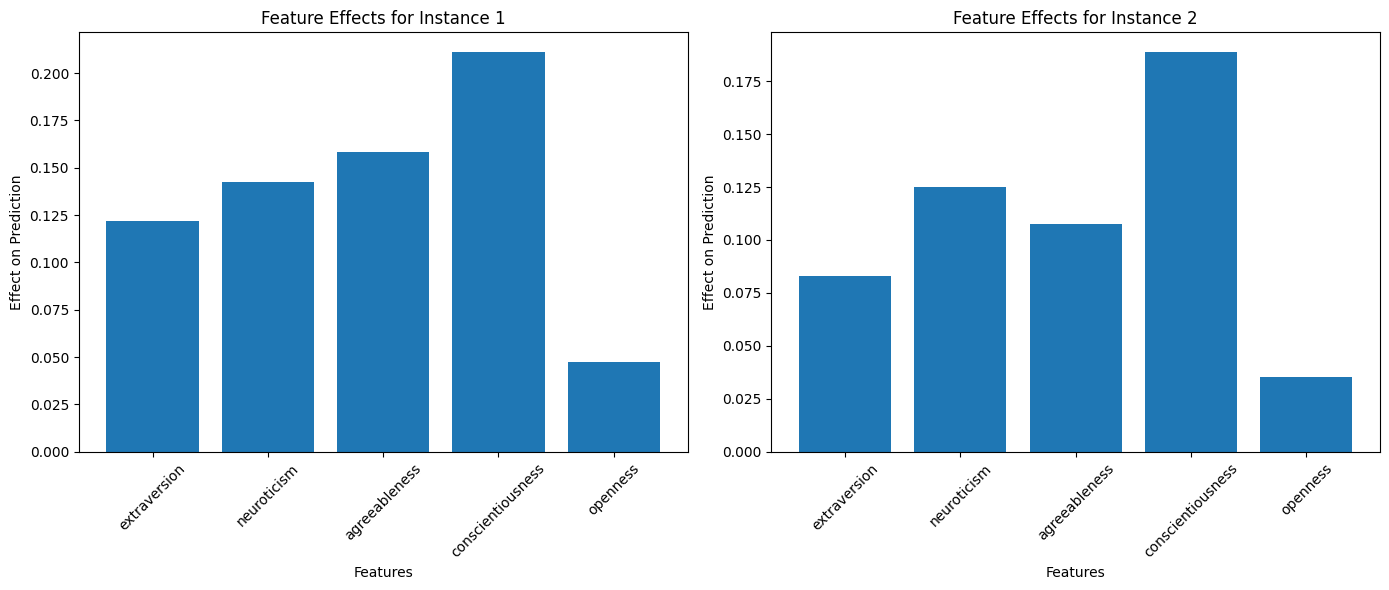

In [30]:
import matplotlib.pyplot as plt
# Compute the Feature Effects

coefficients = result.params[:-1]

instance1 = dev_features.iloc[0][:-1]
instance2 = dev_features.iloc[1][:-1]
feature_effects1 = coefficients * instance1
feature_effects2 = coefficients * instance2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].bar(feature_effects1.index, feature_effects1.values)
axes[0].set_title('Feature Effects for Instance 1')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Effect on Prediction')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(feature_effects2.index, feature_effects2.values)
axes[1].set_title('Feature Effects for Instance 2')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Effect on Prediction')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Q1.5**

Reflection: why would training a regression tree not work well for this dataset in terms of model interpretability? And under what conditions could the dataset be used with a decision tree to yield an interpretable model?

> Answer: 

### **2. Explainable Boosting Model**
Train an Explainable Boosting Machine (EBM) with [InterpretML](https://interpret.ml/docs/ebm.html). EBM is a Generalized Additive Model (GAM) that is highly intelligible and explainable.

The `interpret` package provides both global and local explanation functions: `explain_global()` and `explain_local()` can be used to interpret a ML model.

**Q2.1**

Visualize/provide global (model-wise) feature importances for EBM as a table or figure.

In [5]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show

# EBM Global feature importances

**Q2.2**

What are the most important two features in EBM? Are they the same as in the linear model?

> Answer:

Now, to have an idea how EBM treats the input and generates the explanation, visualize EBM local explanations on a synthetic instance generated from training set mean feature vector as input and training set mean response as output.



In [6]:
# EBM Local explanation for training set mean vector with corresponding training set mean label
train_mean_x = pd.DataFrame(train_features.mean(axis=0)).T
train_mean_y = pd.DataFrame([train_labels.mean()])

print(train_mean_x)
print(train_mean_y)

   extraversion  neuroticism  agreeableness  conscientiousness  openness  \
0      0.476146     0.520286       0.548181           0.522731  0.566281   

   intercept  
0        1.0  
         0
0  0.50378


**Q2.3**

Now, visualize local (instance-wise) feature importances for the first two instances of the development set.

In [ ]:
# EBM local explanations for the first two development set instances

**Q2.4**

Let's compare these feature importances with the feature effects in question 1.4.

* Are the feature contribution orderings the same in both models for the two instances?
> Answer:

* For the second example's explanation, why do you think the contribution of *conscientiousness* is positive, while the contribution of *agreeableness* is negative? (Hint: consider the feature values relative to the training set mean values you calculated / processed in the former subquestion.)
> Answer:

# Part 2. Model-Agnostic Methods for Interpreting/Explaining NN

### **3. Training Neural Networks**
Train a one-layer Neural Network (multi-layer perceptron (MLP) Regressor, but with one layer) with the following settings:

- Activation function: ReLU
- Size of the hidden layer: 50 neurons
- Recommended optimizer/solver: Adam

For a tutorial see [Tutorial](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

**Q3.1**

Apply the trained neural network model to the development set to find the best hyperparameters (such as learning rate). Report the Root Mean Square Error (RMSE) performance measure.

**Note.** A development set RMSE below 0.045 is reasonable, then you can apply the corresponding model on the test set in the next question.

In [7]:
(train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels) = load_data()

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
import itertools
from tqdm import tqdm

# Train the MLPRegressor and show RMSE on development set

lr_mode = ['constant', 'invscaling', 'adaptive']
betas1 = np.linspace(0.8, 0.99, 8)
betas2 = np.linspace(0.8, 0.999, 8)
lrs = np.logspace(-4, -1, 4)
best_rmse = float('inf')
best_lr_mode = None
best_lr = None

for lr_mode, lr, beta1, beta2 in tqdm(list(itertools.product(*[lr_mode, lrs, betas1, betas2]))):
    model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=1000, 
                         learning_rate=lr_mode, learning_rate_init=lr, beta_1=beta1, beta_2=beta2, random_state=42)
    model.fit(train_features, train_labels)
    dev_predictions = model.predict(dev_features)
    rmse = root_mean_squared_error(dev_labels, dev_predictions)
    if rmse < best_rmse:
        best_rmse = rmse
        best_lr_mode = lr_mode
        best_lr = lr

print(f'Best RMSE: {best_rmse}, Best learning rate mode: {best_lr_mode}, Best learning rate: {best_lr}, Best beta1: {beta1}, Best beta2: {beta2}')

100%|██████████| 768/768 [08:57<00:00,  1.43it/s]

Best RMSE: 0.042974875727571776, Best learning rate mode: constant, Best learning rate: 0.001, Best beta1: 0.99, Best beta2: 0.999


**Q3.2**

Now use the best settings to report the Root Mean Square Error (RMSE) performance measure on the test set.

It is possible to use the combination of the training and development sets to retrain the model and report the test set performance. You can also use the model that was trained on the training set only.

In [34]:
big_train_features = pd.concat([train_features, dev_features])
big_train_labels = pd.concat([train_labels, dev_labels])
model = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=1000, learning_rate=best_lr_mode, learning_rate_init=best_lr, beta_1=beta1, beta_2=beta2, random_state=42)
model.fit(big_train_features, big_train_labels)
test_predictions = model.predict(test_features)
test_rmse = root_mean_squared_error(test_labels, test_predictions)
print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.04520703473627932


Now we can analyze factors that influence the predictions. Both Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots can be used to visualize and analyze interaction between the target response and a set of input features of interest.

See the [Documentation](https://scikit-learn.org/stable/modules/partial_dependence.html) on how to use PDPs and ICEs.

**Q3.3**

Generate univariate and bivariate PDPs for the `conscientiousness` and `agreeableness` features with the neural network you trained above.

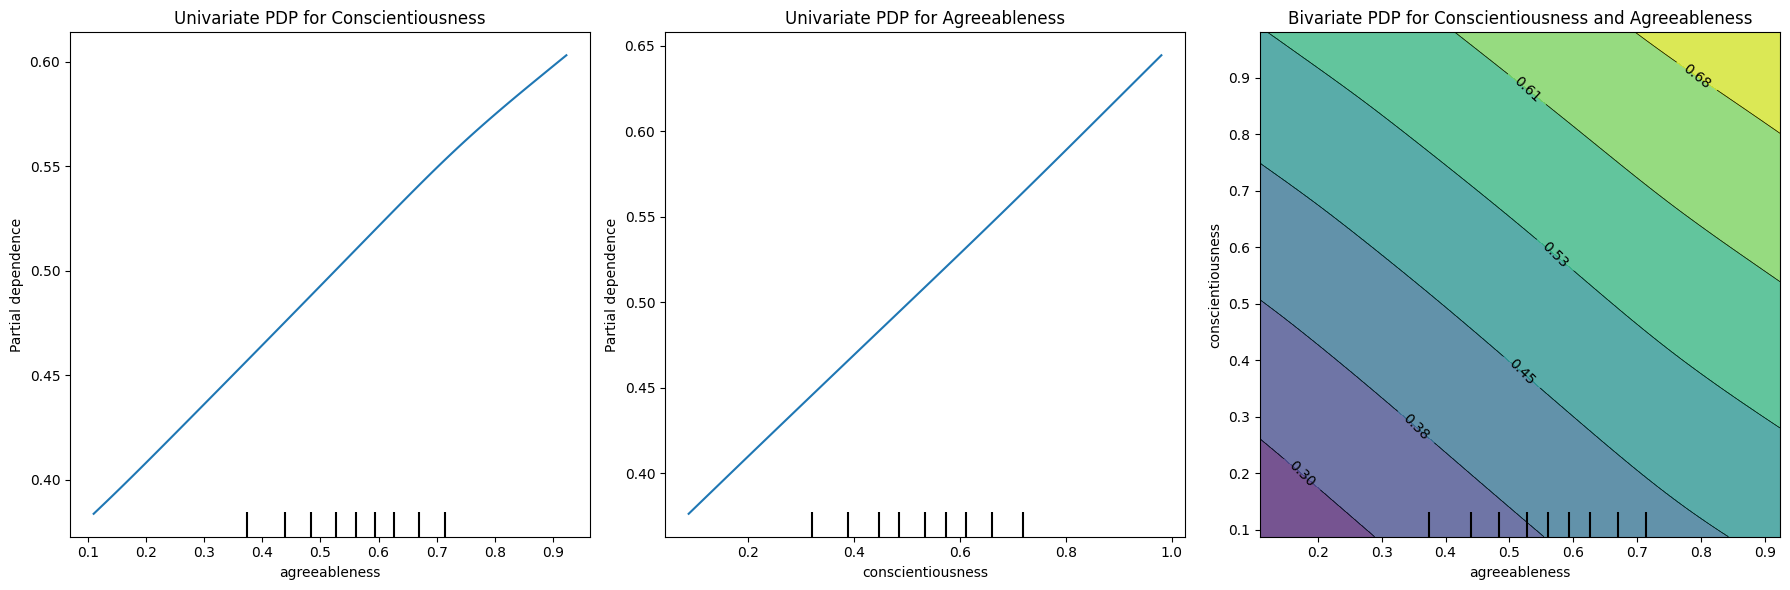

In [35]:
from sklearn.inspection import PartialDependenceDisplay

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
display1 = PartialDependenceDisplay.from_estimator(model, test_features, [2], ax=ax1)
ax1.set_title('Univariate PDP for Conscientiousness')

display2 = PartialDependenceDisplay.from_estimator(model, test_features, [3], ax=ax2)
ax2.set_title('Univariate PDP for Agreeableness')

display3 = PartialDependenceDisplay.from_estimator(model, test_features, [(2, 3)], ax=ax3)
ax3.set_title('Bivariate PDP for Conscientiousness and Agreeableness')

plt.tight_layout()
plt.show()

**Q3.4**

What do these plots show?

> Answer: We can see that increase in both 'agreeableness' and 'conscientiousness' positively contribute to resulting score and the bivariate plot further confirms that the 'conscientiousness' has a stronger contribution towards the final precition (hence the lines we observe are mo slanted rather than being symmetrical)

**Q3.5**

Now generate ICE plots for each feature.

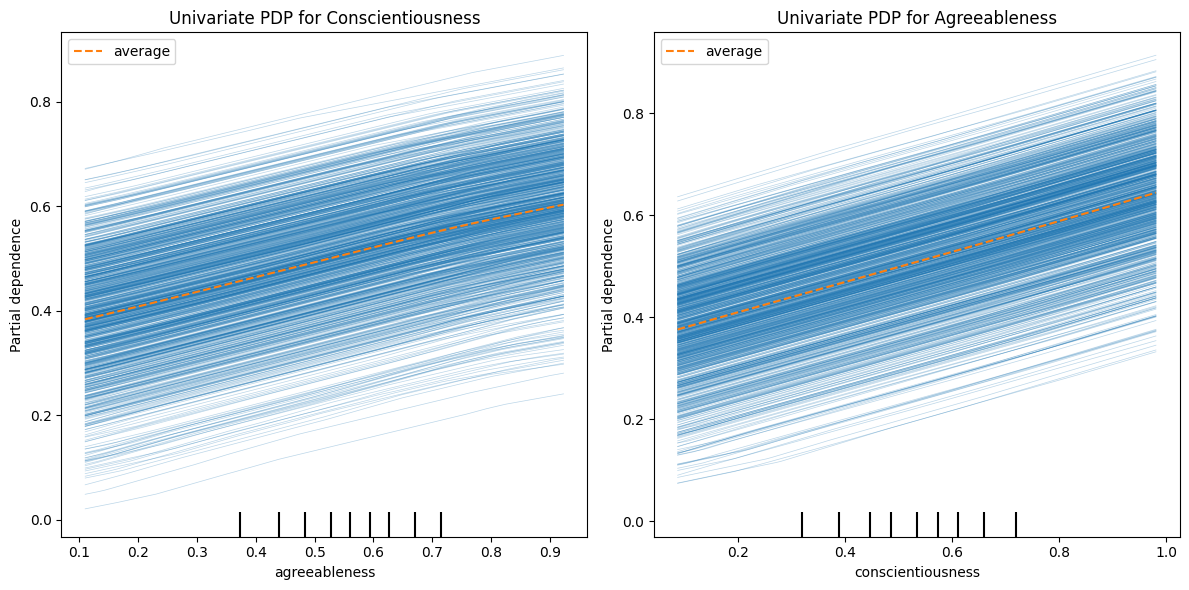

In [36]:
# ICEs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
display1 = PartialDependenceDisplay.from_estimator(model, test_features, [2], ax=ax1, kind='both')
ax1.set_title('Univariate PDP for Conscientiousness')

display2 = PartialDependenceDisplay.from_estimator(model, test_features, [3], ax=ax2, kind='both')
ax2.set_title('Univariate PDP for Agreeableness')

plt.tight_layout()
plt.show()

**Q3.6**

What can you conclude from ICE plots above?

> Answer: We can see that there're no obvious outliers that would ignore the contribution tendency we sai in PDP, however individual samples have a rather strong deviation.

**Q3.7**

Implement the PDF (Partial Dependence Function) for univariate analysis of the trained NN model.


In [40]:
def PDF(X, model, feature):
  """
  Input   Dataset 'X', Model 'model', feature_name 'feature'
  Output  x_values: independent variable values
          f_values: corresponding output per x value
  """
  # Note: uncomment the lines below and complete the right hand side (where you see '..' to set them to suitable values, respective explanations are provided for each variable
  num_samples = len(X)  # set the number of samples/steps to slice the range of the continuous feature, e.g., 100.
  min_val = min(X[feature])      # minimum value of the given feature
  max_val = max(X[feature])      # maximum value of the given feature
  step_size = (max_val - min_val) / (num_samples - 1)   # see the algorithm in corresponsing lecture slides to calculate the step size as a function of the above variables
  x_values = np.linspace(min_val, max_val, num_samples)    # x_values at which we will calculate the partial function of the given feature
  f_values = np.zeros(num_samples)    # the calculated partial function values corresponding to x_values

  for k in range(num_samples):
        X_temp = X.copy()
        X_temp[feature] = x_values[k]
        f_values[k] = model.predict(X_temp).mean()
    
  return x_values, f_values

**Q3.8**

Calculate and visualize the feature importances obtained by your PDF algorithm with a bar graph. How do we calculate the feature importance given the x_values and y_values of the PDF algorithm?

In [41]:
x_v = dict()
f_v = dict()
ftrs = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
for feature in ftrs:
    x_values, f_values = PDF(test_features, model, feature)
    x_v[feature] = x_values
    f_v[feature] = f_values

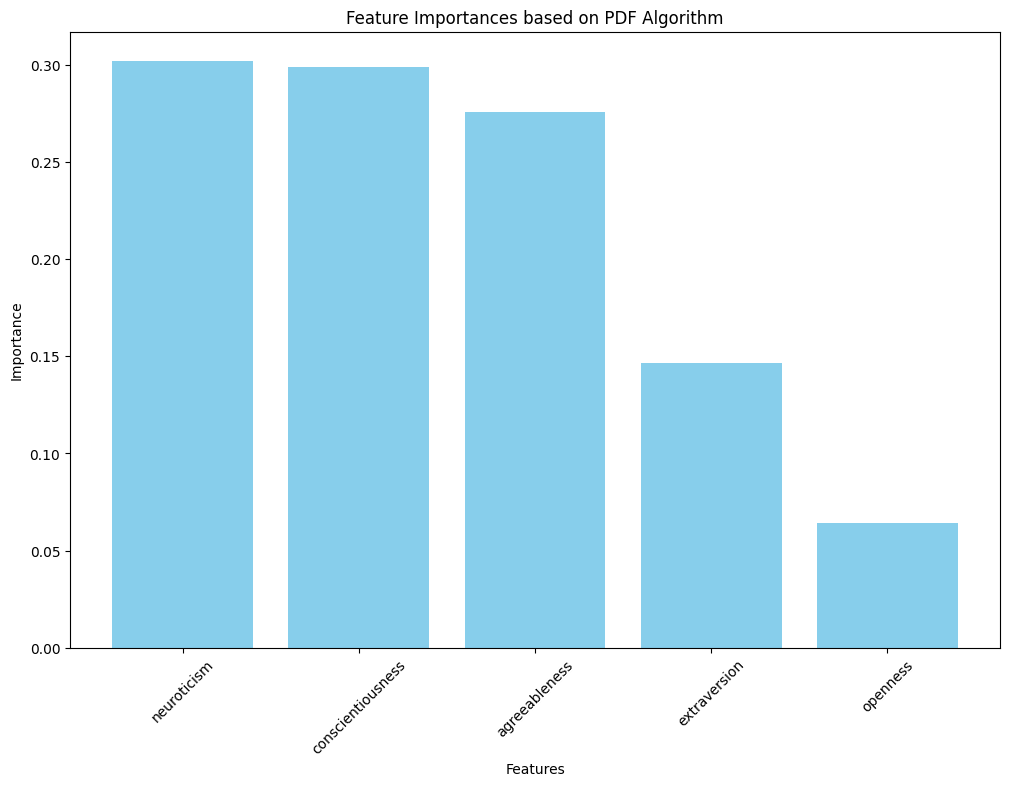

In [42]:
from scipy.stats import linregress

# Fit a linear model per feature, what is the output of this linear model?
feature_importances = dict()

for feature in ftrs:
    x_values, f_values = x_v[feature], f_v[feature]

    slope, intercept, r_value, p_value, std_err = linregress(x_values, f_values)
    
    # Store the absolute value of the slope as the feature importance
    feature_importances[feature] = abs(slope)

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize the feature importances with a bar graph
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances based on PDF Algorithm')
plt.xticks(rotation=45)
plt.show()

**Q3.9**

What are the two most important features obtained by the PDF algorithm for the MLP model? How do these two features compare to the top two features from the Linear Model and the EBM?

> Answer: 


### **4. Permutation Feature Importance**

**Q4.1**

Implement the permutation feature importance algorithm using RMSE as the error function. No existing libraries (barring the RMSE from `sklearn` and a function for random sampling / permutation) are allowed to be used, you will implement it yourself with the framework below.

In [ ]:
def PFI(X, labels, model, base_rmse):
  results = []

  for feature in X:
    # Create a copy of X_test
    # Scramble the values of the given predictor
    # Calculate the new RMSE
    # Append the increase in MSE to the list of results

  # Put the results into a pandas dataframe and rank the predictors by score

  # return results_df

**Q4.2**

Visualize the feature importances obtained by your PFI algorithm with a bar graph.

In [ ]:
# Bar graph of feature importances

**Q4.3**

What are the two most important features obtained by the permutation feature importance algorithm for the MLP model? How do these two features compare to the top two features from the Linear Model and the EBM?

> Answer:

**Q4.4**

Explain two disadvantages of the PFI method.

> Answer: